In [1]:
from keras.models import Sequential, model_from_json
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.constraints import maxnorm
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, SeparableConv2D
from keras.layers import Bidirectional, RepeatVector, TimeDistributed, Permute, Embedding
from keras.layers import concatenate, add, Lambda, multiply
from keras.layers import LSTM
from keras.models import Model
from keras.regularizers import l2
from keras.preprocessing.sequence import pad_sequences

from keras.applications import imagenet_utils, Xception
from keras.preprocessing.image import img_to_array
import keras.backend as K

import numpy as np 
import json
import os
import cv2
import h5py
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
from helpers import TrainingMonitor
from helpers import Utils

In [4]:
X_file = open('../input/dataset/X.pickle', 'rb')
x = pickle.load(X_file)
X_file.close()

In [5]:
Y_file = open('../input/dataset/Y.pickle', 'rb')
y = pickle.load(Y_file)
Y_file.close()

In [6]:
y = np.array(y)

In [7]:
y_input = np.zeros([1000, 10])
y_input[:, 1:] = y[:,:-1]
y_input[:, 0] = -1

In [8]:
y_input[0]

array([ -1.,   2.,  10.,  10.,   9.,   0.,   1.,   6.,   0.,   1.])

In [9]:
Yoh_file = open('../input/dataset/Yoh.pickle', 'rb')
yoh = pickle.load(Yoh_file)
Yoh_file.close()

In [10]:
train_split, val_split = 0.7, 0.15

train_len = int(train_split * x.shape[0])
train_val_len = int((train_split + val_split) * x.shape[0])

x_train = x[:train_len]
x_val = x[train_len:train_val_len]
x_test = x[train_val_len:]

y_input_train = y_input[:train_len]
y_input_val = y_input[train_len:train_val_len]
y_input_test = y_input[train_val_len:]

yoh_train = yoh[:train_len]
yoh_val = yoh[train_len:train_val_len]
yoh_test = yoh[train_val_len:]

In [11]:
x_train.shape

(700, 30)

In [12]:
y_input_train.shape

(700, 10)

In [13]:
yoh_train.shape

(700, 10, 11)

In [14]:
INPUT_LENGTH = 30
OUTPUT_LENGTH = 10
input_dict_size = 37
output_dict_size = 11

In [15]:
encoder_input = Input(shape=(INPUT_LENGTH,))
decoder_input = Input(shape=(OUTPUT_LENGTH,))

In [16]:
encoder = Embedding(input_dict_size, 64, input_length=INPUT_LENGTH, mask_zero=True)(encoder_input)
encoder = LSTM(64, return_sequences=True, unroll=True)(encoder)

print('encoder', encoder)

decoder = Embedding(output_dict_size, 64, input_length=OUTPUT_LENGTH, mask_zero=True)(decoder_input)
decoder = LSTM(64, return_sequences=True, unroll=True)(decoder)

print('decoder', decoder)

encoder Tensor("lstm_1/transpose_2:0", shape=(?, 30, 64), dtype=float32)
decoder Tensor("lstm_2/transpose_2:0", shape=(?, 10, 64), dtype=float32)


In [17]:
from keras.layers import Activation, dot, concatenate

In [18]:
attention = dot([decoder, encoder], axes=[2, 2])
attention = Activation('softmax', name='attention')(attention)
print('attention', attention)

context = dot([attention, encoder], axes=[2,1])
print('context', context)

decoder_combined_context = concatenate([context, decoder])
print('decoder_combined_context', decoder_combined_context)

attention Tensor("attention/truediv:0", shape=(?, 10, 30), dtype=float32)
context Tensor("dot_2/MatMul:0", shape=(?, 10, 64), dtype=float32)
decoder_combined_context Tensor("concatenate_1/concat:0", shape=(?, 10, 128), dtype=float32)


In [19]:
output = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
output = TimeDistributed(Dense(11, activation="softmax"))(output)

In [20]:
model = Model(inputs=[encoder_input, decoder_input], outputs=[output])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 10, 64)       704         input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 64)       2368        input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LS

In [21]:
output_path = "../output/"

print(os.getpid())
filepath=output_path + "progress/seq2seq-attention-weights-best.hdf5"
MC = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

figPath = os.path.sep.join([output_path, "monitor/{}.png".format(os.getpid())])
jsonPath = os.path.sep.join([output_path, "monitor/{}.json".format(os.getpid())])
TM = TrainingMonitor(figPath, jsonPath=jsonPath, startAt=0)

RLR = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)

callbacks = [MC, TM, RLR]

8280


In [22]:
history = model.fit(x=[x_train, y_input_train], y=[yoh_train],
            validation_data=([x_val, y_input_val], [yoh_val]),
            verbose=1,
            batch_size=32,
            epochs=50,
            shuffle="batch")

Train on 700 samples, validate on 150 samples
Epoch 1/50
700/700 [==============================] - 8s 12ms/step - loss: 0.2938 - acc: 0.9090 - val_loss: 0.2817 - val_acc: 0.9091
Epoch 2/50
700/700 [==============================] - 2s 2ms/step - loss: 0.2749 - acc: 0.9085 - val_loss: 0.2665 - val_acc: 0.9091
Epoch 3/50
700/700 [==============================] - 2s 2ms/step - loss: 0.2547 - acc: 0.9120 - val_loss: 0.2404 - val_acc: 0.9130
Epoch 4/50
700/700 [==============================] - 2s 2ms/step - loss: 0.2278 - acc: 0.9206 - val_loss: 0.2161 - val_acc: 0.9287
Epoch 5/50
700/700 [==============================] - 2s 2ms/step - loss: 0.2030 - acc: 0.9369 - val_loss: 0.1925 - val_acc: 0.9420
Epoch 6/50
700/700 [==============================] - 2s 2ms/step - loss: 0.1805 - acc: 0.9457 - val_loss: 0.1724 - val_acc: 0.9461
Epoch 7/50
700/700 [==============================] - 2s 2ms/step - loss: 0.1631 - acc: 0.9482 - val_loss: 0.1593 - val_acc: 0.9473
Epoch 8/50
700/700 [=========

In [23]:
scores = model.evaluate([x_test, y_input_test], yoh_test, verbose=0)
print("Train: %.2f%%; Val: %.2f%%; Test: %.2f%%" % 
      (np.max(history.history['acc'])*100, np.max(history.history['val_acc'])*100, scores[1]*100)
     )

Train: 99.98%; Val: 99.86%; Test: 99.85%


In [24]:
model_json = model.to_json()
with open("../output/saved/date_model_attention_99.81.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("../output/saved/date_weight_attention_99.81.hdf5")

In [25]:
attention_layer = model.get_layer("attention")
attention_model = Model(inputs=model.inputs, outputs=model.outputs + [attention_layer.output])

In [26]:
%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt
import seaborn

In [27]:
human_vocab_file = open('../input/dataset/human_vocab.pickle', 'rb')
human_vocab = pickle.load(human_vocab_file)
human_vocab_file.close()

In [28]:
machine_vocab_file = open('../input/dataset/machine_vocab.pickle', 'rb')
machine_vocab = pickle.load(machine_vocab_file)
machine_vocab_file.close()

In [29]:
input_encoding = human_vocab
output_encoding = machine_vocab
input_decoding = {v: k for k, v in input_encoding.items()}
output_decoding = {v: k for k, v in output_encoding.items()}

In [39]:
encoder_input = x[0:1]
encoder_input.shape

(1, 30)

In [40]:
encoder_input

array([[12,  0, 24, 13, 34,  0,  4, 12, 12, 11, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36]])

In [41]:
decoder_input = y_input[0:1]
decoder_input

array([[ -1.,   2.,  10.,  10.,   9.,   0.,   1.,   6.,   0.,   1.]])

In [42]:
decoder_output= np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))

In [43]:
for i in range(0, 10):
    output, attention = attention_model.predict([encoder_input, decoder_input])
    decoder_output[:,i] = output.argmax(axis=2)[:,i]
    attention_density = attention[0]

In [44]:
decoder_output

array([[  2.,  10.,  10.,   9.,   0.,   0.,   6.,   0.,   0.,  10.]])

In [45]:
text = ''
for key, value in enumerate(encoder_input[0]):
    if value != 36:
        text += str(input_decoding[value])
    else:
        text += ' '
text

'9 may 1998                    '

In [46]:
date = ''
for key, value in enumerate(decoder_output[0]):
    date += str(output_decoding[value])
date

'1998--5--9'

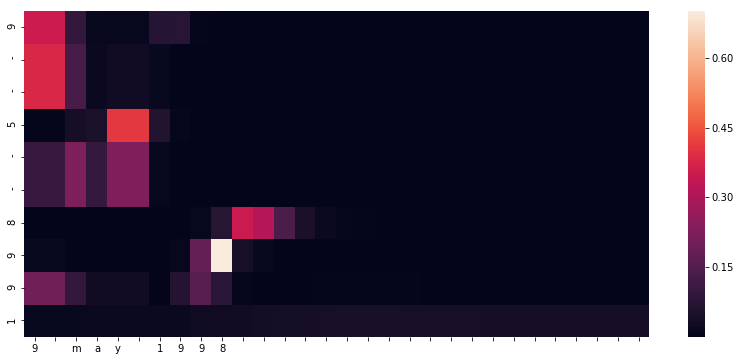

In [47]:
plt.clf()
plt.figure(figsize=(14,6))

ax = seaborn.heatmap(attention_density[:len(date), : len(text)],
        xticklabels=[w for w in text],
        yticklabels=[w for w in date])

ax.invert_yaxis()
plt.show()